# Graph Mining Lab03 (220927)

# ✅ 실습파일 제출안내
- Task : 아이캠퍼스에서 실습용 파일 다운 받아서, 빈칸 채우기
- 파일명: lab03-학번.ipynb
- 아이캠퍼스에 제출
- 기한: 금일 자정까지 (00:00)

# ✅ [Lab03] 실습 구성
1. 4주차 수업 내용 실습 
    - Motif
    - graph role (RolX)
    - Structural similarity
    - Centrality
    - Community detection (5주차 내용 예습)

2. Node/Link/Graph Classification 개괄설명
    - Dataset
    - Inductive/Transductive
    - Implementation


---

# [Environment Setting]

In [41]:
# Install DGL library
!pip install -q dgl-cu113 dglgo -f https://data.dgl.ai/wheels/repo.html

In [2]:
!pip install h5py 
!pip install typing-extensions 
!pip install wheel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [42]:
import dgl
import torch
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### Benchmark dataset load

- https://docs.dgl.ai/api/python/dgl.data.html
- Cora citation network dataset.
  - node : 머신러닝 관련 논문
  - edge : 논문 간 인용 여부
  - node feature : 1 X 1433 - 1433개 단어집합에서 해당 논문이 단어를 포함하고 있는지 유무로 word vector
  - label : 7개 class ('Case_Based',
 'Genetic_Algorithms', 'Neural_Networks',
 'Probabilistic_Methods',  'Reinforcement_Learning', 'Rule_Learning','Theory')

- Karate Club Graph 
  - Node : 클럽 회원 (34명)
  - Edge : 회원 간의 상호작용
  - label : Mr. Hi, Officier (클럽 커뮤니티)

In [43]:
# node classification용 데이터셋이라서 그래프가 한 개 들어있음.
# 만약 graph classification 용 데이터셋인 경우엔 여러 graph가 포함되어있음 (뒤쪽에서 다시 설명)
dataset = dgl.data.CoraGraphDataset()
graph = dataset[0]

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [44]:
# cora dataset은 node 수가 많아서 colab에서 시각화하기가 힘들어서, karateclub으로 하겠음
dataset = dgl.data.KarateClubDataset()
graph = dataset[0]

In [45]:
# mask 정보는 나중에 모델 학습을 위해 필요함.
graph

Graph(num_nodes=34, num_edges=156,
      ndata_schemes={'label': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={})

In [46]:
labels = graph.ndata['label']

In [47]:
labels

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

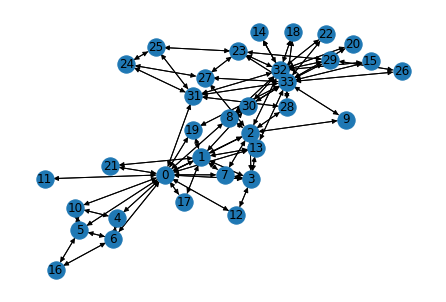

In [48]:
# visualization
nx_G = dgl.to_networkx(graph)
nx.draw(nx_G, with_labels=True)

---

## 1) Motif - subgraph
- https://docs.dgl.ai/generated/dgl.node_subgraph.html
- dgl.node_subgraph(graph, nodes, *, relabel_nodes=True, store_ids=True, output_device=None)
- original graph에서 특정 노드 id를 입력해주면, 그 노드들 만으로 이루어진 subgraph를 뽑아줌. (i.e. node-induced graph)

In [49]:
sg = dgl.node_subgraph(graph,list(range(10))) # 0~10번 노드 지정

In [50]:
sg

Graph(num_nodes=10, num_edges=36,
      ndata_schemes={'label': Scheme(shape=(), dtype=torch.int64), '_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)})

In [51]:
sg.edges()

(tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4,
         5, 5, 6, 6, 6, 7, 7, 7, 7, 8, 8, 9]),
 tensor([1, 2, 3, 4, 5, 6, 7, 8, 0, 2, 3, 7, 0, 1, 3, 7, 8, 9, 0, 1, 2, 7, 0, 6,
         0, 6, 0, 4, 5, 0, 1, 2, 3, 0, 2, 2]))

## 1) Motif - recurring: count subgraphs

In [52]:
# https://pypi.org/project/netsci/
# https://github.com/gialdetti/netsci
# https://github.com/gialdetti/netsci/blob/master/examples/network_motifs.ipynb
! pip install netsci

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [53]:
import numpy as np
import netsci.visualization as nsv
import netsci.metrics.motifs as nsm

In [54]:
nx_G = dgl.to_networkx(graph) 
nx_G_rd = random_G = nx.erdos_renyi_graph(nx_G.number_of_nodes(), 0.01, seed=2022, directed=False) #예제 graph는 undirected라서 motif 모양을 보긴 힘듦

In [55]:
nx.info(nx_G_rd)

'Name: \nType: Graph\nNumber of nodes: 34\nNumber of edges: 3\nAverage degree:   0.1765'

In [56]:
nx.info(nx_G)

'Name: \nType: MultiDiGraph\nNumber of nodes: 34\nNumber of edges: 156\nAverage in degree:   4.5882\nAverage out degree:   4.5882'

In [57]:
# networkx to numpy
g_np = nx.convert_matrix.to_numpy_matrix(nx_G,dtype=np.integer)
g_r_np = nx.convert_matrix.to_numpy_matrix(nx_G_rd,dtype=np.integer)

print(g_np.shape,g_r_np.shape)

(34, 34) (34, 34)


In [58]:
g_freq= nsm.motifs(g_np)
rd_freq= nsm.motifs(g_r_np)

print(g_freq)
print(rd_freq)

[ -1  -1  -1   0   0   0   0   0   0   0 393   0   0   0   0  45]
[-1 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]


[ 1  2  3  4  5  6  7  8  9 10 11 12 13]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13]


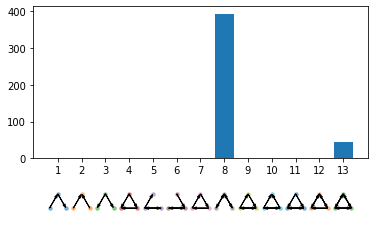

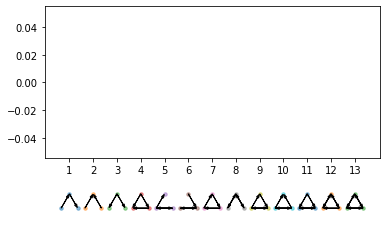

In [59]:
# visualization of motifs
nsv.bar_motifs(g_freq)
nsv.bar_motifs(rd_freq)

## 2) graph role (RolX)
- reference: https://github.com/dkaslovsky/GraphRole
- https://pypi.org/project/graphrole/
- Automatic feature extraction and node role assignment for transfer learning on graphs; based on the ReFeX/RolX

In [60]:
! pip -q install graphrole
! pip -q install scikit-learn==0.24.2
! pip -q install numpy==1.19.5
! pip -q install pandas==1.1.5
! pip -q install networkx==2.5.1
! pip -q install scipy==1.5.4

In [61]:
from pprint import pprint
import seaborn as sns

from graphrole import RecursiveFeatureExtractor, RoleExtractor

In [62]:
# extract features
nx_G = dgl.to_networkx(graph) 
feature_extractor = RecursiveFeatureExtractor(nx_G)
features = feature_extractor.extract_features()

In [25]:
features

,external_edges(mean)(mean),external_edges(mean),in_degree(mean),in_degree(sum),external_edges,in_degree,internal_edges
0,19.637500,24.937500,4.312500,69.0,17,16,68
1,22.422685,27.666667,5.777778,52.0,19,9,42
2,25.537083,27.100000,6.600000,66.0,34,10,42
3,23.717361,25.666667,7.666667,46.0,20,6,32
4,17.979167,16.000000,7.666667,23.0,16,3,10
5,17.234375,13.000000,6.250000,25.0,15,4,14
6,17.234375,13.000000,6.250000,25.0,15,4,14
7,26.342708,22.500000,10.250000,41.0,25,4,20
8,27.214363,25.000000,11.800000,59.0,44,5,20
9,28.108824,26.000000,13.500000,27.0,25,2,4


In [26]:
# assign node roles
role_extractor = RoleExtractor(n_roles=None)
role_extractor.extract_role_factors(features)
node_roles = role_extractor.roles

In [27]:
print('\nNode role assignments:')
pprint(node_roles)

print('\nNode role membership by percentage:')
print(role_extractor.role_percentage.round(2))


Node role assignments:
{0: 'role_0',
 1: 'role_6',
 2: 'role_6',
 3: 'role_6',
 4: 'role_1',
 5: 'role_0',
 6: 'role_0',
 7: 'role_5',
 8: 'role_2',
 9: 'role_1',
 10: 'role_1',
 11: 'role_1',
 12: 'role_1',
 13: 'role_2',
 14: 'role_1',
 15: 'role_1',
 16: 'role_1',
 17: 'role_1',
 18: 'role_1',
 19: 'role_2',
 20: 'role_1',
 21: 'role_1',
 22: 'role_1',
 23: 'role_6',
 24: 'role_1',
 25: 'role_1',
 26: 'role_1',
 27: 'role_1',
 28: 'role_1',
 29: 'role_5',
 30: 'role_1',
 31: 'role_2',
 32: 'role_6',
 33: 'role_6'}

Node role membership by percentage:
    role_0  role_1  role_2  role_3  role_4  role_5  role_6
0     0.31    0.02    0.02    0.31    0.02    0.02    0.31
1     0.12    0.02    0.02    0.12    0.12    0.12    0.47
2     0.09    0.02    0.21    0.02    0.21    0.09    0.36
3     0.03    0.14    0.03    0.03    0.14    0.14    0.52
4     0.06    0.34    0.06    0.06    0.06    0.06    0.34
5     0.19    0.19    0.03    0.03    0.19    0.19    0.19
6     0.19    0.19    0.03

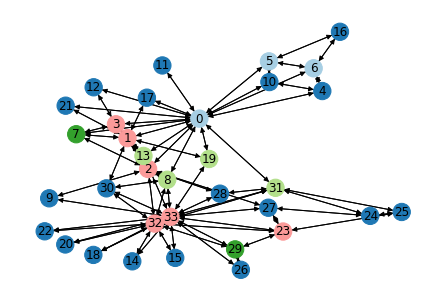

In [28]:
# build color palette for plotting
unique_roles = sorted(set(node_roles.values()))
color_map = sns.color_palette('Paired', n_colors=len(unique_roles))
# map roles to colors
role_colors = {role: color_map[i] for i, role in enumerate(unique_roles)}
# build list of colors for all nodes in G
node_colors = [role_colors[node_roles[node]] for node in nx_G.nodes]

# plot graph
plt.figure()
nx.draw(
    nx_G,
    pos=nx.spring_layout(nx_G, seed=42),
    with_labels=True,
    node_color=node_colors,
)
plt.show()

## 3) Structural similarity

In [29]:
sim = nx.simrank_similarity(nx_G)

In [30]:
sim

{0: {0: 1,
  1: 0.3264222284357432,
  2: 0.27509612240375475,
  3: 0.31925271926524357,
  4: 0.30511444840380836,
  5: 0.2916903530055296,
  6: 0.29169035300552965,
  7: 0.29419009643807337,
  8: 0.23765418040167957,
  9: 0.24742698424201787,
  10: 0.30511444840380836,
  11: 0.25186982237236744,
  12: 0.2888561614849804,
  13: 0.2752068408395463,
  14: 0.1987164058121515,
  15: 0.1987164058121515,
  16: 0.3251960851782854,
  17: 0.2776688675580512,
  18: 0.1987164058121515,
  19: 0.2515371845205133,
  20: 0.1987164058121515,
  21: 0.2776688675580512,
  22: 0.1987164058121515,
  23: 0.1993971165539162,
  24: 0.22617149776290052,
  25: 0.22368216371474225,
  26: 0.19964503584394774,
  27: 0.22173062106059538,
  28: 0.2579439812899722,
  29: 0.20073903703214685,
  30: 0.2507906056157244,
  31: 0.2086533355503722,
  32: 0.23545550964360162,
  33: 0.24134825833450443},
 1: {0: 0.3264222284357433,
  1: 1,
  2: 0.29405611775598195,
  3: 0.33678502330121596,
  4: 0.28249973970458675,
  5: 0.26

## 4) Node Centrality
- degree centrality : 연결된 node가 많을 수록 큼. nx.degree_centrality(g), nx.in_degree_centrality(g), nx.out_degree_centrality(g)
- closeness centrality : 모든 node와의 거리가 가까울 수록 큼. nx.closeness_centrality(g)
- betweenness centrality : 노드 간의 경로에 있을 수록 큼. nx.betweenness_centrality(g, normalized=True)
- eigenvector centrality : 큰 네트워크와 연결되있는 사람일 수록 큼. nx.eigenvector_centrality(g)

In [31]:
nx_G = nx.DiGraph(nx_G)
print(nx.info(nx_G))
# dgl -> networkx : Multigraph
# 이 타입으로는 뒤에 함수 수행이 안된다고 함.
# 그래서 타입 변형.

Name: 
Type: DiGraph
Number of nodes: 34
Number of edges: 156
Average in degree:   4.5882
Average out degree:   4.5882


In [32]:
degree_centrality = nx.degree_centrality(nx_G) 
closeness_centrality = nx.closeness_centrality(nx_G)
betweenness_centrality = nx.betweenness_centrality(nx_G, normalized=True)
eigenvector_centrality = nx.eigenvector_centrality(nx_G)

In [33]:
degree_centrality # node 별로 값 나옴

{0: 0.9696969696969697,
 1: 0.5454545454545454,
 2: 0.6060606060606061,
 3: 0.36363636363636365,
 4: 0.18181818181818182,
 5: 0.24242424242424243,
 6: 0.24242424242424243,
 7: 0.24242424242424243,
 8: 0.30303030303030304,
 9: 0.12121212121212122,
 10: 0.18181818181818182,
 11: 0.06060606060606061,
 12: 0.12121212121212122,
 13: 0.30303030303030304,
 14: 0.12121212121212122,
 15: 0.12121212121212122,
 16: 0.12121212121212122,
 17: 0.12121212121212122,
 18: 0.12121212121212122,
 19: 0.18181818181818182,
 20: 0.12121212121212122,
 21: 0.12121212121212122,
 22: 0.12121212121212122,
 23: 0.30303030303030304,
 24: 0.18181818181818182,
 25: 0.18181818181818182,
 26: 0.12121212121212122,
 27: 0.24242424242424243,
 28: 0.18181818181818182,
 29: 0.24242424242424243,
 30: 0.24242424242424243,
 31: 0.36363636363636365,
 32: 0.7272727272727273,
 33: 1.0303030303030303}

## 5) Community Detection

- Girvan-Newman alogorithm for community detection
    - Hierarchical clustering based on edges betweenness
    - Selecting number $k$ of communities
        - Pick $k$ so that modularity (a measure of how well a network is partitioned into communities) at $k$ is maximized
- *Reference* : [girvan_newman()](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.centrality.girvan_newman.html#networkx.algorithms.community.centrality.girvan_newman)

In [34]:
from networkx.algorithms import community
comp = community.girvan_newman(nx_G)
communities = tuple(sorted(c) for c in next(comp))
for i, comm_nodes in enumerate(communities):
    print('community {}th'.format(i))
    print(comm_nodes, end='\n')

community 0th
[0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21]
community 1th
[2, 8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]


In [35]:
com_dict = {}
for i, comm_nodes in enumerate(communities):
    for node in comm_nodes:
      com_dict[node] = i

In [36]:
com_dict

{0: 0,
 1: 0,
 3: 0,
 4: 0,
 5: 0,
 6: 0,
 7: 0,
 10: 0,
 11: 0,
 12: 0,
 13: 0,
 16: 0,
 17: 0,
 19: 0,
 21: 0,
 2: 1,
 8: 1,
 9: 1,
 14: 1,
 15: 1,
 18: 1,
 20: 1,
 22: 1,
 23: 1,
 24: 1,
 25: 1,
 26: 1,
 27: 1,
 28: 1,
 29: 1,
 30: 1,
 31: 1,
 32: 1,
 33: 1}

In [37]:
sorted_com_dict ={n:l for n,l in sorted(com_dict.items())}

In [38]:
df = pd.DataFrame()
df['node_ids'] = range(len(graph.ndata['label']))
df['true_label'] = graph.ndata['label']
df['com_label'] = sorted_com_dict.values()#df['node_ids'].apply(lambda x : com_dict[x])

In [39]:
df

,node_ids,true_label,com_label
0,0,0,0
1,1,0,0
2,2,0,1
3,3,0,0
4,4,0,0
5,5,0,0
6,6,0,0
7,7,0,0
8,8,0,1
9,9,1,1


# 실습

- 수업 시간에 사용한 benchmark 데이터 셋 이외의 데이터셋 load (networkx 데이터셋 사용 가능)
- node 별 centrality (종류별), community detection 결과 dataframe으로 출력 

** 제출 시 주의사항 
- 제출 전 빈 템플릿인지 확인 (출석은 하였으나 빈 템플릿 제출 시 0.5/1)
- 실습에서 다룬 내용보다 더 효율적인 방법 사용 가능 및 추천
- 이외 실습 내용 방법 사용하지 않은 경우 감점 (0.9/1)
  - ex) 인접행렬 이용해 그래프 구축 시 torch.tensor().T 방법 사용하지 않고, manual하게 edge 행렬 만든 경우

In [65]:
pip install rdflib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 500 kB 2.1 MB/s 
     |████████████████████████████████| 41 kB 636 kB/s 


In [98]:
#### 1. 필요한 라이브러리 import ###
import dgl
import torch
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


dataset = dgl.data.CiteseerGraphDataset()
graph = dataset[0]
graph = dgl.to_networkx(graph)
print(nx.info(graph))

  NumNodes: 3327
  NumEdges: 9228
  NumFeats: 3703
  NumClasses: 6
  NumTrainingSamples: 120
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
Name: 
Type: MultiDiGraph
Number of nodes: 3327
Number of edges: 9228
Average in degree:   2.7737
Average out degree:   2.7737


In [105]:
#### 1. 필요한 라이브러리 import ###
import dgl
import torch
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


################################
#### 2. benchmark 데이터셋 load 
dataset = dgl.data.KarateClubDataset()
graph = dataset[0]
nx_G = dgl.to_networkx(graph)
print(nx.info(nx_G))

################################
### 3. centrality 구하기 
nx_G = nx.DiGraph(nx_G)

degree_centrality = nx.degree_centrality(nx_G) 
closeness_centrality = nx.closeness_centrality(nx_G)
betweenness_centrality = nx.betweenness_centrality(nx_G, normalized=True)
eigenvector_centrality = nx.eigenvector_centrality(nx_G)

################################
#### 4. community detection 
from networkx.algorithms import community
comp = community.girvan_newman(nx_G)
communities = tuple(sorted(c) for c in next(comp))
for i, comm_nodes in enumerate(communities):
    print('community {}th'.format(i))
    print(comm_nodes, end='\n')

################################
#### 5. 노드 별 정보 출력 
# - 포함되어야 할 것 : node id, centrality (4가지), community detection 결과, 실제 class 정보
df = pd.DataFrame()

df['node_ids'] = range(len(graph.ndata['label']))
df['d_centrality'] = degree_centrality.values()
df['c_centrality'] = closeness_centrality.values()
df['b_centrality'] = betweenness_centrality.values()
df['e_centrality'] = eigenvector_centrality.values()
df['com_detect'] = sorted_com_dict.values()
df['true_label'] = graph.ndata['label']
df
################################

Name: 
Type: MultiDiGraph
Number of nodes: 34
Number of edges: 156
Average in degree:   4.5882
Average out degree:   4.5882
community 0th
[0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21]
community 1th
[2, 8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]


,node_ids,d_centrality,c_centrality,b_centrality,e_centrality,com_detect,true_label
0,0,0.969697,0.568966,0.437635,0.355483,0,0
1,1,0.545455,0.485294,0.053937,0.265954,0,0
2,2,0.606061,0.559322,0.143657,0.317189,1,0
3,3,0.363636,0.464789,0.011909,0.211174,0,0
4,4,0.181818,0.379310,0.000631,0.075966,0,0
5,5,0.242424,0.383721,0.029987,0.079481,0,0
6,6,0.242424,0.383721,0.029987,0.079481,0,0
7,7,0.242424,0.440000,0.000000,0.170955,0,0
8,8,0.303030,0.515625,0.055927,0.227405,1,0
9,9,0.121212,0.434211,0.000848,0.102675,1,1


In [107]:
# expected result
df

,node_ids,d_centrality,c_centrality,b_centrality,e_centrality,com_detect,true_label
0,0,0.969697,0.568966,0.437635,0.355483,0,0
1,1,0.545455,0.485294,0.053937,0.265954,0,0
2,2,0.606061,0.559322,0.143657,0.317189,1,0
3,3,0.363636,0.464789,0.011909,0.211174,0,0
4,4,0.181818,0.379310,0.000631,0.075966,0,0
5,5,0.242424,0.383721,0.029987,0.079481,0,0
6,6,0.242424,0.383721,0.029987,0.079481,0,0
7,7,0.242424,0.440000,0.000000,0.170955,0,0
8,8,0.303030,0.515625,0.055927,0.227405,1,0
9,9,0.121212,0.434211,0.000848,0.102675,1,1


# Node, Link, Graph Classification
- ppt 자료 참고